<a href="https://colab.research.google.com/github/Fatimat01/pred_music_composer_cnn/blob/Greg_Bauer/Project_Report_Team2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greg Bauer
## Final Project - Team 2
### AAI-511 Summer 2025

In [2]:
# Install the 'pretty_midi' library: provides MIDI parsing, synthesis, and manipulation capabilities
# Used for extracting note-level data, pitch, velocity, timing, and control events from .mid files
!pip install pretty_midi --quiet

# Install 'tensorflow': core deep learning framework for building and training models
# Required for implementing CNN→LSTM and MLP architectures used in composer classification
!pip install tensorflow --quiet

In [3]:
import zipfile
import pickle
import tensorflow as tf
import zipfile

# Core filesystem operations (e.g. loading MIDI files from directories)
import os

# Efficient array computation, mathematical operations, and broadcasting logic
import numpy as np

# Parses and manipulates symbolic music data from MIDI files
import pretty_midi

# Structured data handling for feature tables and model inputs/outputs
import pandas as pd

# Plotting utilities for statistical and heatmap-style visualizations
import seaborn as sns
import matplotlib.pyplot as plt  # Standard tool for 2D plotting and axis control

# Common mathematical functions for preprocessing and scoring
import math

# Recursive search to find files using wildcard patterns (e.g., all .mid files)
from glob import glob

# Deep learning model definition API used for building CNN → LSTM hybrid models
from tensorflow.keras.models import Model

# Sequential and time-aware layers for hybrid architecture:
# - Input: defines entry point and shape of input data
# - TimeDistributed: applies CNN layers independently to each frame
# - Conv2D: extracts spatial pitch patterns per time step
# - MaxPooling2D: compresses learned features by reducing resolution
# - Flatten: converts image-like frames into vectors
# - LSTM: learns long-term musical dependencies and phrasing
# - Dense: fully connected decision layers
# - Dropout: helps generalize by randomly disabling units during training
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout

# Label encoding and one-hot conversion for composer classification
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Pads input sequences to equal length for uniform training batches
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Training control callbacks:
# - EarlyStopping: halts training when validation loss plateaus
# - ModelCheckpoint: saves model only when performance improves
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Splits dataset into training and validation sets with stratified label distribution
from sklearn.model_selection import train_test_split

from google.colab import drive, files


In [4]:
tf.debugging.set_log_device_placement(True)

In [5]:
uploaded = files.upload()

zip_path = "NN_midi_files_extended.zip"
extract_path = "NN_midi_files_extended"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction complete.")


Saving NN_midi_files_extended.zip to NN_midi_files_extended.zip
✅ Extraction complete.


In [6]:
# Set a global debug flag: enables or disables verbose output across notebook
DEBUG = False  # Toggle this to True when debugging

# Suppress runtime warnings for cleaner notebook output when DEBUG is False
# This avoids clutter from harmless numerical or audio-related warnings (e.g., librosa or pretty_midi)
import warnings
if not DEBUG:
    warnings.filterwarnings("ignore", category=RuntimeWarning)

## What Are .mid Files?

`.mid` files are the standard extension for **Musical Instrument Digital Interface (MIDI)** files. MIDI is a protocol that stores musical instructions rather than sound — enabling digital devices to communicate performance data.

---

### How MIDI Files Work

A `.mid` file encodes structured event data, including:
- Note pitches, start and end times, and velocities (volume)
- Tempo and time signature changes
- Instrument assignments and control signals

These files are interpreted by synthesizers, software instruments, or music production tools to generate audio. Unlike audio recordings (e.g., .mp3 or .wav), `.mid` files are compact and easily editable.

---

### Why They're Used in Machine Learning

- Small file size and efficient to process
- Structured, symbolic representation ideal for extracting features like note density or chord distribution
- Enables data augmentation through pitch and tempo manipulation

---

**Source:**  
- [MIDI Technical Specification by the MIDI Manufacturers Association](https://www.midi.org/specifications)

---

In [7]:
file_path_dev = "NN_midi_files_extended/NN_midi_files_extended/dev/"
file_path_train = "NN_midi_files_extended/NN_midi_files_extended/train/"
file_path_test = "NN_midi_files_extended/NN_midi_files_extended/test/"

---
### *2. Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.*
---

In [8]:
# Load a MIDI file and label it with its composer
def load_midi(file_path):
    try:
        # Use PrettyMIDI to parse the file into an object for analysis and manipulation
        # Source: https://craffel.github.io/PrettyMIDI
        midi = pretty_midi.PrettyMIDI(file_path)
        # Extract the composer name based on the parent directory structure
        composer = os.path.basename(os.path.dirname(file_path))
        return midi, composer
    except Exception as e:
        # If the file fails to load, report the issue and skip it
        print(f"Error loading {file_path}: {e}")
        return None, None

# Remove unwanted instruments to simplify downstream processing
def sanitize_midi(midi):
    # Keep only instruments with 'piano' in their name and remove all drum tracks
    # This ensures stylistic consistency across inputs (e.g., modeling piano performance only)
    # MIDI program definitions: https://www.midi.org/specifications-old/item/the-midi-1-0-specification
    midi.instruments = [
        inst for inst in midi.instruments
        if not inst.is_drum and 'piano' in inst.name.lower()
    ]
    return midi

# Remove expressive metadata that could introduce bias or inconsistencies
def reassign_control_changes(midi):
    # Control changes include parameters like volume, pan, modulation
    # These are often arbitrary across MIDI files and may hurt model generalization
    # Source: PrettyMIDI instrument API: https://craffel.github.io/PrettyMIDI/generated/pretty_midi.Instrument.html
    for inst in midi.instruments:
        inst.control_changes.clear()
    return midi

# Create data variations by simulating transpositions and tempo shifts
def augment_midi(midi, pitch_shift=0, tempo_factor=1.0):
    for inst in midi.instruments:
        for note in inst.notes:
            # Shift the pitch of each note up/down by pitch_shift semitones
            # Clip to valid MIDI pitch range [0, 127]; Source: MIDI spec
            note.pitch = np.clip(note.pitch + pitch_shift, 0, 127)
            # Multiply start and end times to simulate different playing speeds
            note.start *= tempo_factor
            note.end *= tempo_factor
    return midi

# Recursively load, clean, and augment all MIDI files in a dataset
def process_midi_directory(root_dir, pitch_shifts=[0, 2, -2], tempo_factors=[1.0, 1.1, 0.9]):
    processed = []

    # Find all .mid files inside composer subfolders using pattern matching
    # Source: Python glob module — https://docs.python.org/3/library/glob.html
    midi_files = glob(f"{root_dir}/**/*.mid", recursive=True)

    for file_path in midi_files:
        # Load and label the MIDI file
        midi, composer = load_midi(file_path)
        if not midi:
            continue

        # Filter instrument tracks and clean out control data
        midi = sanitize_midi(midi)
        midi = reassign_control_changes(midi)

        # Apply combinations of pitch and tempo augmentation
        for ps in pitch_shifts:
            for tf in tempo_factors:
                # Reload the original file to avoid compound modifications
                midi_aug = augment_midi(pretty_midi.PrettyMIDI(file_path), pitch_shift=ps, tempo_factor=tf)

                # Append the augmented sample and its metadata
                processed.append({
                    "composer": composer,                     # Source label
                    "file": os.path.basename(file_path),      # Original filename
                    "pitch_shift": ps,                        # Semitone shift applied
                    "tempo_factor": tf,                       # Tempo scaling factor
                    "midi": midi_aug                          # Resulting MIDI object
                })

    # Return the full list of processed samples
    return processed


In [ ]:
processed = process_midi_directory(file_path_train)
print(f"Number of MIDI files processed: {len(processed)}")
print(f"Example composer: {processed[0]['composer']}")
print(f"Example file: {processed[0]['file']}")

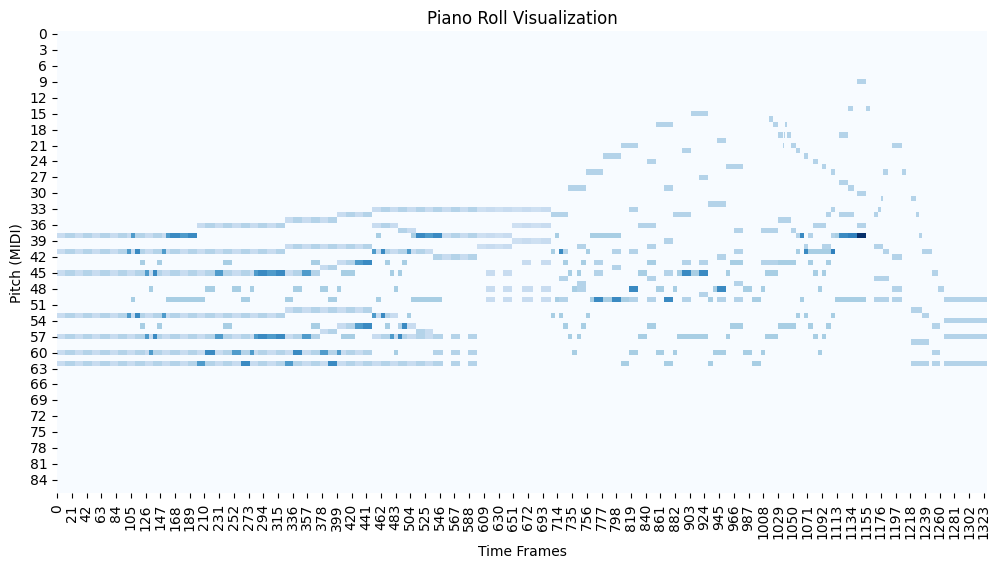

In [11]:
def plot_piano_roll(midi, fs=25, pitch_range=(21, 108)):
    roll = midi.get_piano_roll(fs=fs)[pitch_range[0]:pitch_range[1]]
    plt.figure(figsize=(12, 6))
    sns.heatmap(roll, cmap='Blues', cbar=False)
    plt.xlabel("Time Frames")
    plt.ylabel("Pitch (MIDI)")
    plt.title("Piano Roll Visualization")
    plt.show()

# Example:
plot_piano_roll(processed[0]['midi'])



### MIDI File Visualization Explained

This graphic illustrates the structure of a MIDI file using a **piano roll representation**, a common way to visualize symbolic music data.

### Grid Layout
- **Horizontal Rows**: Represent musical pitches, labeled from **C2 to C5**.
- **Vertical Columns**: Represent time intervals, evenly spaced to show rhythmic progression.

### MIDI Notes
- **Turquoise Bars**: Each bar corresponds to a MIDI note.
  - **Vertical Position**: Indicates the pitch (e.g., C3, C4).
  - **Horizontal Length**: Indicates the duration of the note.
- **Example**:
  - A long bar in the **C2** row spans nearly the entire width, suggesting a sustained bass note.
  - Multiple shorter bars in **C3–C5** rows show melodic or harmonic activity.

### Purpose
This visualization helps:
- Understand **note timing and pitch** at a glance.
- Analyze **musical structure** for tasks like composer classification or genre detection.
- Serve as input for deep learning models (e.g., CNN→LSTM) that process symbolic music data.

---
### *3. Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.*  
---

In [12]:
def midi_to_pianoroll_tensor(midi, fs=25, pitch_range=(21, 108), max_duration=30.0):
    """
    Convert a PrettyMIDI object into a normalized piano roll tensor suitable for CNN→LSTM input.

    Parameters:
    - midi: PrettyMIDI object representing a parsed MIDI file.
    - fs: Frame rate in Hz (frames per second). Lower values reduce temporal resolution and memory usage.
    - pitch_range: Tuple defining the pitch bounds to extract (default is full piano range: A0 to C8).
    - max_duration: Maximum duration (in seconds) to retain from the MIDI file. Longer files are truncated.

    Returns:
    - A 3D numpy array of shape (time_steps, pitch_bins, 1), normalized to [0, 1], ready for Conv2D layers.
    """

    # Truncate long MIDI files to avoid excessive memory usage
    # This is critical because get_piano_roll allocates memory proportional to duration × fs
    # We iterate over each instrument and remove notes that start after max_duration
    for inst in midi.instruments:
        inst.notes = [note for note in inst.notes if note.start < max_duration]

    # Generate the piano roll matrix
    # PrettyMIDI's get_piano_roll returns a (128, time_frames) matrix of velocities
    # Each row corresponds to a MIDI pitch (0–127), each column to a time frame
    # fs=50 means 20ms resolution, which balances temporal fidelity and memory efficiency
    full_roll = midi.get_piano_roll(fs=fs)

    # Restrict to standard piano pitch range
    # This removes unused or irrelevant pitches (e.g., percussion, extreme registers)
    # A0 (21) to C8 (108) covers 88 keys, but we use 87 bins: [21, 108)
    roll = full_roll[pitch_range[0]:pitch_range[1], :]  # Shape: (87, time_frames)

    # Transpose to time-major format
    # Deep learning models typically expect input as (time_steps, features)
    # Here, each time step contains a vector of pitch activations
    roll = roll.T  # New shape: (time_steps, 87)

    # Normalize velocity values to [0, 1]
    # MIDI velocities range from 0 to 127; normalization ensures consistent scale
    # If the roll is silent (all zeros), we avoid division by zero
    roll = roll / 127.0 if roll.max() > 0 else np.zeros_like(roll)

    # Add channel dimension for CNN compatibility
    # Keras Conv2D expects input shape: (time_steps, pitch_bins, channels)
    # We treat each time slice as a "grayscale image" with 1 channel
    roll = np.expand_dims(roll, axis=-1)  # Final shape: (time_steps, 87, 1)

    return roll


In [13]:
# Create empty lists to hold:
# - X: model inputs (each is a 3D piano roll tensor extracted from a MIDI file)
# - y: target labels (composer names, one per tensor)
X = []  # Feature set: piano roll tensors for each augmented MIDI file
y = []  # Label set: composer identifiers (to be encoded)

# Iterate over all processed and augmented MIDI samples
for entry in processed:
    # Convert MIDI data into a piano roll tensor
    # Each tensor captures temporal pitch activation in the shape (time_steps, pitch_bins, 1 channel)
    # These are suitable for TimeDistributed Conv2D layers followed by LSTM
    # Reference: https://craffel.github.io/PrettyMIDI/generated/pretty_midi.PrettyMIDI.html#get_piano_roll
    tensor = midi_to_pianoroll_tensor(entry['midi'])

    # Add the tensor to training features
    X.append(tensor)

    # Add the associated composer label as the training target
    # This label will be numerically encoded and one-hot transformed before model training
    # Reference: Label encoding for classification — https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
    y.append(entry['composer'])


---
### *4. Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.*
---

In [14]:
def build_cnn_lstm_model(input_shape, num_classes):
    # Define input layer with shape: (time, pitch, channel)
    inputs = Input(shape=input_shape)

    # Apply CNN layers frame-by-frame using TimeDistributed
    # Each frame is treated as a 2D "image" with pitch axis and channel dimension
    x = TimeDistributed(Conv2D(32, (5, 1), activation='relu'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 1)))(x)
    x = TimeDistributed(Flatten())(x)

    # Feed sequence of CNN features into LSTM layer
    # LSTM learns temporal dependencies across piano roll frames
    x = LSTM(128)(x)

    # Dropout helps prevent overfitting during training
    x = Dropout(0.3)(x)

    # Fully connected layer for deeper representation
    x = Dense(64, activation='relu')(x)

    # Final output layer with softmax activation for classification
    outputs = Dense(num_classes, activation='softmax')(x)

    # Define and compile the model
    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',  # suitable for multi-class classification
        metrics=['accuracy']
    )

    return model


In [15]:
# Convert composer names into integer class labels
# LabelEncoder assigns a unique integer to each composer name
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Integer labels: [0, 1, 2, ...]

# Convert integer labels into one-hot vectors
# This is required by softmax output and categorical_crossentropy loss
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
y_onehot = to_categorical(y_encoded)

# You can also access the class names like this:
# class_names = label_encoder.classes_

# Now y_onehot is your final target array for model training
# Each label is a vector of length equal to the number of composers


In [16]:
# First, convert X to a NumPy array of objects (since tensors may vary in shape)
X_padded = pad_sequences(X, maxlen=2000, padding='post', dtype='float32')

print(X_padded.shape)  # Should be (num_samples, max_time, pitch_bins, 1)


(3321, 2000, 87, 1)


In [17]:
# Save feature and label arrays
np.save("X_padded.npy", X_padded)
np.save("y_onehot.npy", y_onehot)

# Save label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Save processed MIDI metadata
with open("processed_midi_data.pkl", "wb") as f:
    pickle.dump(processed, f)

print("✅ All files saved.")

with zipfile.ZipFile("composer_data_bundle.zip", "w") as zipf:
    zipf.write("X_padded.npy")
    zipf.write("y_onehot.npy")
    zipf.write("label_encoder.pkl")
    zipf.write("processed_midi_data.pkl")

print("✅ Bundle created: composer_data_bundle.zip")

from google.colab import files
files.download("composer_data_bundle.zip")

✅ All files saved.
✅ Bundle created: composer_data_bundle.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# After padding sequences, expand the tensor to add a second spatial dimension
# Original shape: (samples, time_steps, pitch_bins, 1)
# New shape:      (samples, time_steps, pitch_bins, 1, 1)
# This ensures compatibility with Conv2D inside TimeDistributed
X_reshaped = np.expand_dims(X_padded, axis=-1)

# Split the reshaped input data and one-hot encoded labels into training and validation sets
# - 'stratify': ensures class distribution stays balanced across both sets
# - 'test_size': allocates 20% of data for validation
# - 'random_state': ensures reproducibility of the split
X_train, X_val, y_train, y_val = train_test_split(
    X_reshaped, y_onehot,
    stratify=y_encoded,
    test_size=0.2,
    random_state=42
)

# Reduce training set size for faster iteration
#X_train_small = X_train[:500]
#y_train_small = y_train[:500]

# Optional: reduce validation set too
#X_val_small = X_val[:100]
#y_val_small = y_val[:100]

# Extract input dimensions from a single training sample
# These dimensions are passed into the model to define the input layer shape
time_dim, pitch_dim, width_dim, channel_dim = X_train.shape[1:]

# Build the CNN→LSTM hybrid model using the computed input shape and number of classes
# - 'input_shape': defines the structure of each input sample (per time step frame)
# - 'num_classes': sets the output dimension for softmax classification
model = build_cnn_lstm_model(
    input_shape=(time_dim, pitch_dim, width_dim, channel_dim),
    num_classes=len(label_encoder.classes_)
)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:loc

In [ ]:
# Create TensorFlow datasets for efficient training
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create subset datasets for quick testing
train_subset = tf.data.Dataset.from_tensor_slices((X_train_small, y_train_small))
train_subset = train_subset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_subset = tf.data.Dataset.from_tensor_slices((X_val_small, y_val_small))
val_subset = val_subset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2000, 87, 1, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 2000, 83, 1,    │           192 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 2000, 41, 1,    │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 2000, 1312)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       737,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 746,825 (2.85 MB)

 Trainable params: 746,825 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

### **Model Architecture Explained in Plain Terms**

This model is built to listen to music (as a piano roll) and figure out which composer might have written it. It does this step by step, analyzing each slice of the music and learning how musical ideas evolve over time.

#### **Layer Breakdown and Their Roles**

| **Layer**                  | **What It Means (In Plain Terms)**                                                                 |
|---------------------------|-----------------------------------------------------------------------------------------------------|
| `TimeDistributed(Conv2D)` | Treats each moment of the music like a mini image and applies 32 pattern detectors to find motifs. It scans vertically across pitches to detect things like chords, intervals, or melodic contours. |
| `MaxPooling2D((2,1))`     | Simplifies the detected patterns by reducing pitch resolution—like shrinking the image—while keeping essential information. This helps the model focus on broad musical shapes. |
| `Flatten`                 | Converts each compressed musical slice into a row of numbers that the model can understand and learn from. This step prepares each moment for sequence learning. |
| `LSTM(128)`               | Acts like musical memory—it learns how these patterns change over time, allowing the model to recognize phrasing, repetition, or rhythmic flow across the piece. |
| `Dropout(0.3)`            | A regularization trick that randomly turns off some neurons during training to prevent the model from memorizing noise. Think of it like practicing blindfolded to improve intuition. |
| `Dense(64)`               | Combines learned ideas into higher-level insights before making a prediction. It’s a final interpretation layer that distills what's been learned. |
| `Dense(9)`                | Outputs 9 numbers that represent how likely the piece belongs to each composer. The highest number points to the model’s best guess. |

---

### **Additional Stats and What They Tell Us**

- **Parameter Count**: ~747,000 → This is how many things the model can tune as it learns. It's efficient enough to train quickly but expressive enough to capture real musical structure.
- **Features After Flattening**: 1,312 values per moment in time → These represent all the musical information pulled from the convolutional layers, giving the LSTM plenty of texture to learn from.
- **Output Shape**: `(None, 9)` → For every music sample, the model gives a vector of 9 scores, one for each composer. It picks the one with the highest score as its prediction.

---

This architecture combines visual pattern recognition (like reading sheet music) with temporal listening (like following a melody), making it especially well-suited for composer classification tasks.


---
### *5. Model Training: Train the deep learning model using the pre-processed and feature-extracted data.*  
---

In [ ]:
# ==========================================
# TRAINING SETUP WITH CONFIGURABLE FEATURES
# ==========================================

# Toggle switches for enabling/disabling optional training features
USE_GPU_CHECK        = True   # Check for GPU and report availability
USE_MIXED_PRECISION  = True   # Use float16 operations to boost training speed on compatible GPUs
USE_TENSORBOARD      = True   # Log training metrics and histograms for monitoring in TensorBoard
USE_LR_SCHEDULER     = True   # Adjust learning rate dynamically to improve convergence and stability
AUTO_SCALE_BATCH     = True   # Increase batch size automatically if GPU is available

# ------------------------------------------
# Device Check: Report available GPUs
# ------------------------------------------
if USE_GPU_CHECK:
    from tensorflow.config import list_physical_devices
    gpus = list_physical_devices('GPU')
    print("Available GPUs:", gpus)
    if not gpus:
        print("⚠️ No GPU detected — training will run on CPU")

# ------------------------------------------
# Mixed Precision: Enable float16 operations
# Reduces memory footprint and speeds up computation
# Recommended for Volta/Turing/Ampere GPUs (e.g. RTX series)
# ------------------------------------------
if USE_MIXED_PRECISION:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision policy:", mixed_precision.global_policy())

# ------------------------------------------
# TensorBoard: Real-time training dashboard
# View metrics at http://localhost:6006 after running:
# tensorboard --logdir logs/fit/
# ------------------------------------------
if USE_TENSORBOARD:
    import datetime
    from tensorflow.keras.callbacks import TensorBoard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)
    print("TensorBoard logging to:", log_dir)

# ------------------------------------------
# Learning Rate Scheduler: Reduce LR every 10 epochs
# Helps model fine-tune toward convergence after initial progress
# ------------------------------------------
if USE_LR_SCHEDULER:
    from tensorflow.keras.callbacks import LearningRateScheduler
    def lr_schedule(epoch, lr):
        if epoch % 10 == 0 and epoch != 0:
            return lr * 0.5
        return lr
    lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# ------------------------------------------
# Core Keras Callbacks
# EarlyStopping prevents wasteful training beyond optimal point
# ModelCheckpoint saves best weights based on validation performance
# ------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss to prevent overfitting
    patience=5,                   # Wait up to 5 epochs for improvement
    restore_best_weights=True     # Revert to best weights when training ends
)

checkpoint = ModelCheckpoint(
    filepath='cnn_lstm_best_model.h5',  # Path to save best model
    save_best_only=True                 # Save only if model improves
)

# ------------------------------------------
# Auto-scaling batch size based on GPU availability
# Larger batches improve training throughput when enough memory is available
# ------------------------------------------
batch_size = 32

'''
if AUTO_SCALE_BATCH and USE_GPU_CHECK and gpus:
    batch_size = 64
    print("Batch size auto-scaled to:", batch_size)
'''

# ------------------------------------------
# Assemble final callback list based on active features
# ------------------------------------------
callbacks = [early_stop, checkpoint]
if USE_TENSORBOARD:
    callbacks.append(tensorboard_cb)
if USE_LR_SCHEDULER:
    callbacks.append(lr_scheduler)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision policy: <DTypePolicy "mixed_float16">
TensorBoard logging to: logs/fit/20250718-002632
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Execu

In [ ]:
# ------------------------------------------
# Model Training: Fit CNN→LSTM on piano roll tensors
# ------------------------------------------
# - 'epochs': upper bound for training duration
# - 'batch_size': number of samples used per training step
# - 'validation_data': separate dataset used to evaluate generalization
# - 'callbacks': applies monitoring, logging, regularization, and adaptive control
# - 'verbose': controls verbosity of training output (1 = per epoch update)
USE_SUBSET = True  # Set to False for full training

if USE_SUBSET:
    train_data = train_subset
    val_data = val_subset
    epochs = 10
else:
    train_data = train_dataset
    val_data = val_dataset
    epochs = 30

history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=callbacks,
    verbose=1
)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
# tensorboard --logdir=logs/fit

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN→LSTM Training Curve')
plt.show()


---
### *6. Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.*  
---

---
### *7. Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.*  
---